In [1]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.distributions import Normal

import math

from Data import *
from nets.LTU import LTU, encoder, decoder
from flows.build import build_flow

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def base_dist():
    return Normal(
        loc=torch.zeros(2, device=device),
        scale=torch.ones(2, device=device),
    )

In [4]:
batch_size = 2
Data = Data('two_moons.csv')

train_dataloader, test_dataloader = Data.return_dataloaders(batch_size = batch_size)

num_batches = train_dataloader.__len__()
 

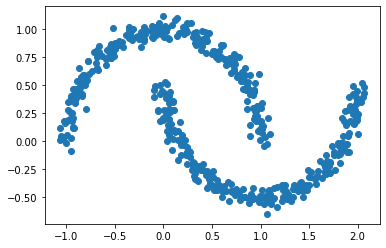

In [5]:
Data.plot_scatter()

## Planar

In [6]:
enc = encoder(hidden_sizes=[128, 64, 2*2]).to(device)
net = LTU()
dec = decoder(hidden_sizes=[64, 128, 2]).to(device)
# net

In [7]:
flow_planar= build_flow(name = 'planar', net = net, dim= 10, device = device).flow.to(device)
# print(flow_planar)

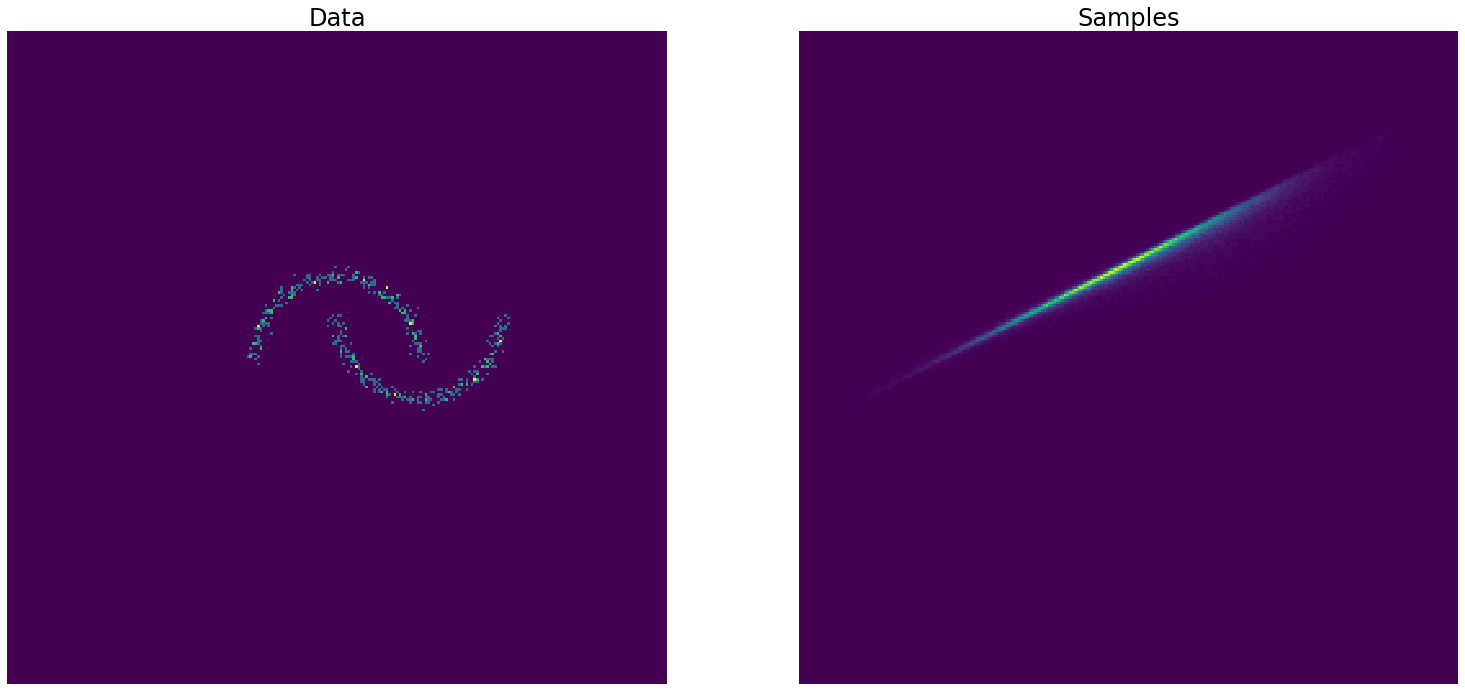

In [8]:
Data.plot_samples(flow_planar.sample(128000))

In [ ]:
loss_fn = BCEWithLogitsLoss()

#Train

optimizer = torch.optim.Adam(list(enc.parameters()) + list(flow_planar.parameters()) + list(dec.parameters()))
epochs = 500

print('Training...')

flow_planar = flow_planar.train()

for epoch in range(epochs):
    loss_sum = 0.0
    for i, x in enumerate(train_dataloader):
        batch_size = len(x)
        x = x.to(device)
        optimizer.zero_grad()
        x_ = enc(x)
        mu, log_sigma = x_[:,0:2], x_[:,2:4]
        sigma = torch.exp(log_sigma)
        
        # Sample from z ~ N(0,I).        
        z = torch.zeros(size= [batch_size,1]).normal_(mean=0, std=1)
        z = z.to(device)
        z0 = z*sigma + mu
        
        log_prob_z0 = torch.sum(-0.5 * torch.log(torch.tensor(2 * math.pi)) - 
                                log_sigma - 0.5 * ((z0 - mu) / sigma) ** 2, axis=1)
        
        zk, log_det = flow_planar.flow_outputs(z0)
        log_prob_zk = torch.sum(-0.5 * (torch.log(torch.tensor(2 * math.pi))+ zk ** 2), axis=1)
        x_hat = dec(zk)

        loss = torch.mean(log_prob_z0) + loss_fn(x_hat, x) - torch.mean(log_prob_zk) - torch.mean(log_det)
        loss.backward()
        optimizer.step()
        loss_sum += loss.detach().cpu().item()
    print('Epoch: {}/{}, Loss: {:.3f}'.format(epoch+1, epochs, loss_sum/len(train_dataloader)))
flow_planar = flow_planar.eval()

Training...
Epoch: 1/500, Loss: 1.441
Epoch: 2/500, Loss: 0.459
Epoch: 3/500, Loss: 0.075
Epoch: 4/500, Loss: -0.484
Epoch: 5/500, Loss: -1.869
Epoch: 6/500, Loss: -2.951
Epoch: 7/500, Loss: -2.799
Epoch: 8/500, Loss: -3.435
Epoch: 9/500, Loss: -3.576
Epoch: 10/500, Loss: -3.580
Epoch: 11/500, Loss: -3.666
Epoch: 12/500, Loss: -4.007
Epoch: 13/500, Loss: -4.131
Epoch: 14/500, Loss: -4.350
Epoch: 15/500, Loss: -4.451
Epoch: 16/500, Loss: -4.041
Epoch: 17/500, Loss: -4.886
Epoch: 18/500, Loss: -4.643
Epoch: 19/500, Loss: -4.858
Epoch: 20/500, Loss: -4.181
Epoch: 21/500, Loss: -5.150
Epoch: 22/500, Loss: -5.053
Epoch: 23/500, Loss: -5.177
Epoch: 24/500, Loss: -4.343
Epoch: 25/500, Loss: -5.026
Epoch: 26/500, Loss: -5.475
Epoch: 27/500, Loss: -5.367
Epoch: 28/500, Loss: -5.674
Epoch: 29/500, Loss: -5.679
Epoch: 30/500, Loss: -5.987
Epoch: 31/500, Loss: -5.548
Epoch: 32/500, Loss: -5.569
Epoch: 33/500, Loss: -5.548
Epoch: 34/500, Loss: -6.308
Epoch: 35/500, Loss: -6.047
Epoch: 36/500, Loss:

Epoch: 287/500, Loss: -6.069
Epoch: 288/500, Loss: -6.062
Epoch: 289/500, Loss: -6.018
Epoch: 290/500, Loss: -5.987
Epoch: 291/500, Loss: -6.117
Epoch: 292/500, Loss: -6.311
Epoch: 293/500, Loss: -6.150
Epoch: 294/500, Loss: -6.001
Epoch: 295/500, Loss: -6.421
Epoch: 296/500, Loss: -6.321
Epoch: 297/500, Loss: -5.706
Epoch: 298/500, Loss: -6.467
Epoch: 299/500, Loss: -6.371
Epoch: 300/500, Loss: -6.356
Epoch: 301/500, Loss: -5.870
Epoch: 302/500, Loss: -6.207
Epoch: 303/500, Loss: -5.894
Epoch: 304/500, Loss: -5.950
Epoch: 305/500, Loss: -6.026
Epoch: 306/500, Loss: -6.358
Epoch: 307/500, Loss: -6.144
Epoch: 308/500, Loss: -6.112
Epoch: 309/500, Loss: -6.240
Epoch: 310/500, Loss: -6.414
Epoch: 311/500, Loss: -5.999
Epoch: 312/500, Loss: -6.378
Epoch: 313/500, Loss: -6.155
Epoch: 314/500, Loss: -6.376
Epoch: 315/500, Loss: -5.950
Epoch: 316/500, Loss: -6.120
Epoch: 317/500, Loss: -5.955
Epoch: 318/500, Loss: -6.011
Epoch: 319/500, Loss: -6.180
Epoch: 320/500, Loss: -6.227
Epoch: 321/500

In [ ]:
Data.plot_samples(flow_planar.sample(128000))